In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [2]:
data = pd.read_excel("./data/online_retail.xlsx")

In [3]:
data.shape

(541909, 8)

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

### Global outliers detection

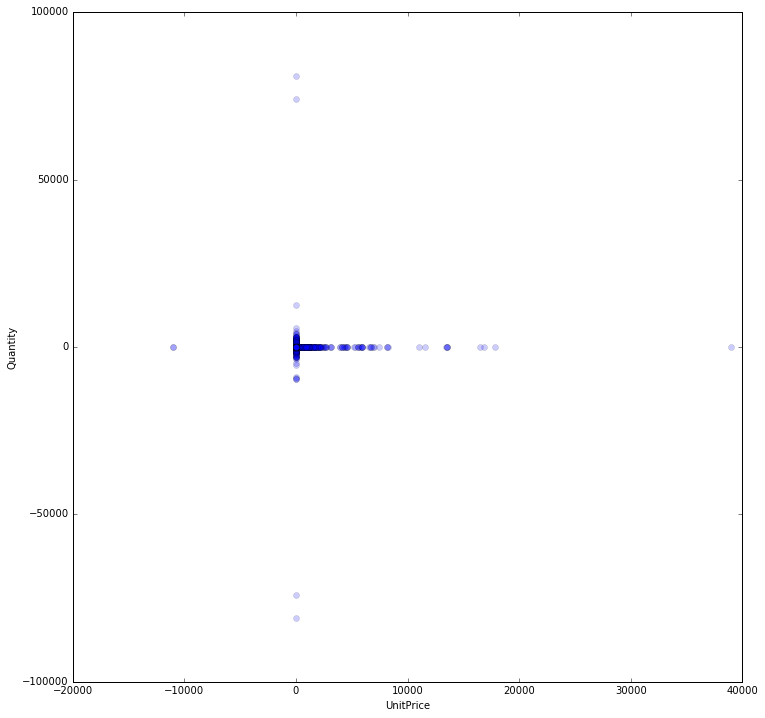

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

Well, we have transactions where unit price is negative.

In [8]:
data[data.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


And also several transactions with negative quantity.

In [9]:
neg_qty = data[data.Quantity < 0]
np.mean(neg_qty.InvoiceNo.apply(lambda s: str(s)[0] == 'C'))

0.87424698795180722

Most of them are cancelled, but what about others?

In [10]:
neg_qty_not_cnl = neg_qty[neg_qty.InvoiceNo.apply(lambda s: str(s)[0] != 'C')]

In [11]:
neg_qty_not_cnl.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom


In [12]:
neg_qty_not_cnl.Description.value_counts()

check                           120
damages                          45
damaged                          42
?                                41
sold as set on dotcom            20
Damaged                          14
thrown away                       9
Unsaleable, destroyed.            9
??                                7
damages?                          5
wet damaged                       5
ebay                              5
smashed                           4
wet pallet                        3
missing                           3
CHECK                             3
wet/rusty                         2
Dotcom sales                      2
damages wax                       2
wet rusty                         2
incorrect stock entry.            2
sold as 1                         2
adjustment                        2
stock check                       2
mixed up                          2
printing smudges/thrown away      2
crushed                           2
rusty throw away            

Those ones which are cancelled have normal invoices. Other do not. Anyway, it's better to consider them as noise and drop.

In [333]:
data = data[data.Quantity > 0]
data = data[data.UnitPrice > 0]

Okay, so as to get global outliers we can use statistical methods. First let's examine distributions of quantities and prices.

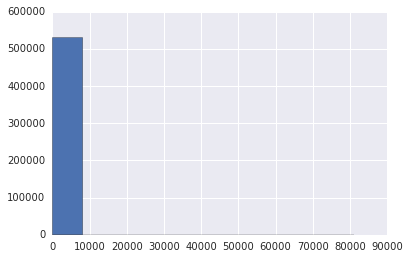

In [326]:
bins = plt.hist(data.Quantity);

Let's take a closer look

In [327]:
data_trimmed = data[(data.Quantity < 10000) & (data.Quantity > 0)]

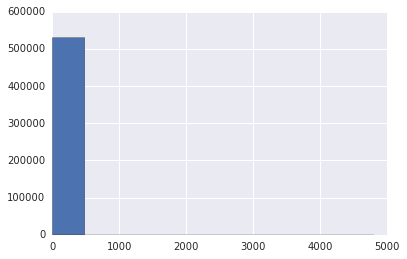

In [328]:
plt.hist(data_trimmed.Quantity);

Okay, the vast majority of examples lies very close to zero.

In [329]:
data_trimmed = data[(data.Quantity < 50) & (data.Quantity > 0)]

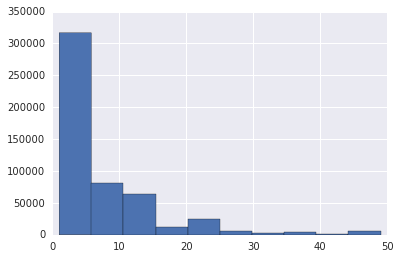

In [330]:
plt.hist(data_trimmed.Quantity);

Here we can assume exponential distribution, however we know that there are common packages (e.g. 24 or 100 units). So, probably we can define as outliers transactions with very uncommon quantity. However, it could be better to use kernel density estimations, because this method is non-parametric. Nevertheless, bandwidth is a tunable parameter, so some supervision is required.

Selecting bandwidth is crucial for Kernel Density Estimation, so, let's do some cross_validation and find optimal bandwidth.

In [342]:
kd = KernelDensity(bandwidth=100)
kd.fit(np.expand_dims(data.Quantity.values, 1))
dqv = np.unique(data.Quantity.values)
log_pdf = kd.score_samples(np.expand_dims(dqv, 1))

So, there are half a million points in the array and an estimation about distribution. So, let's find points which has very low probability on PDF:

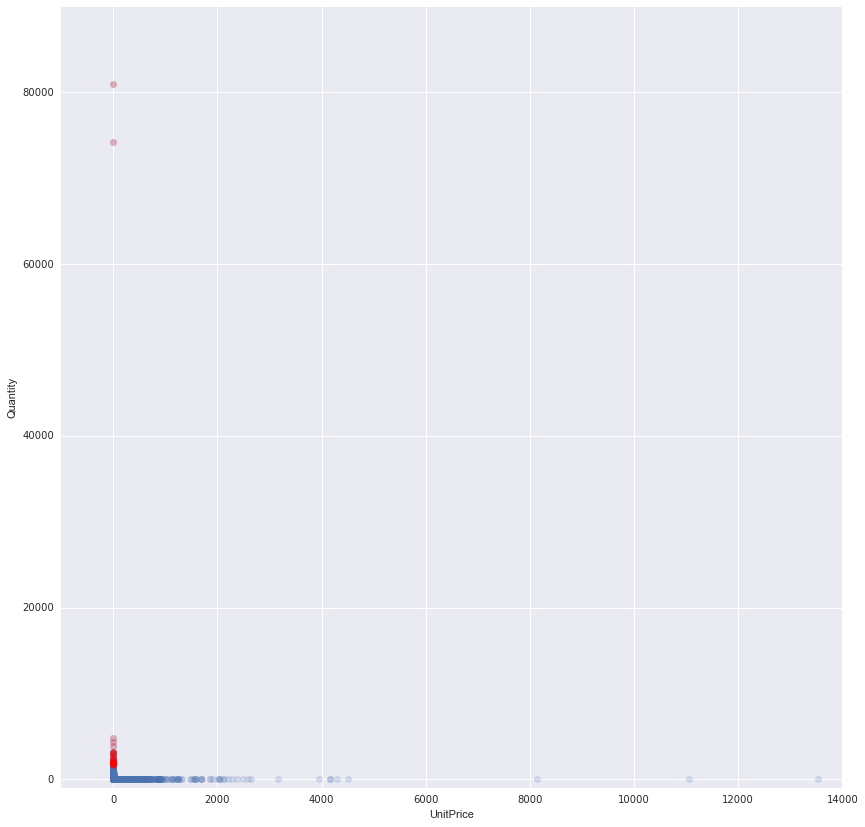

In [345]:
q = data.Quantity
p = data.UnitPrice

outlier_quantity = dqv[np.exp(log_pdf) < 0.0000001]
outliers_sel = np.vectorize(lambda x: x in outlier_quantity)(q)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
ax.set_xlim(-1000, 14000)
ax.set_ylim(-1000, 90000)
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

Let's drop the two highest points and take closer look.

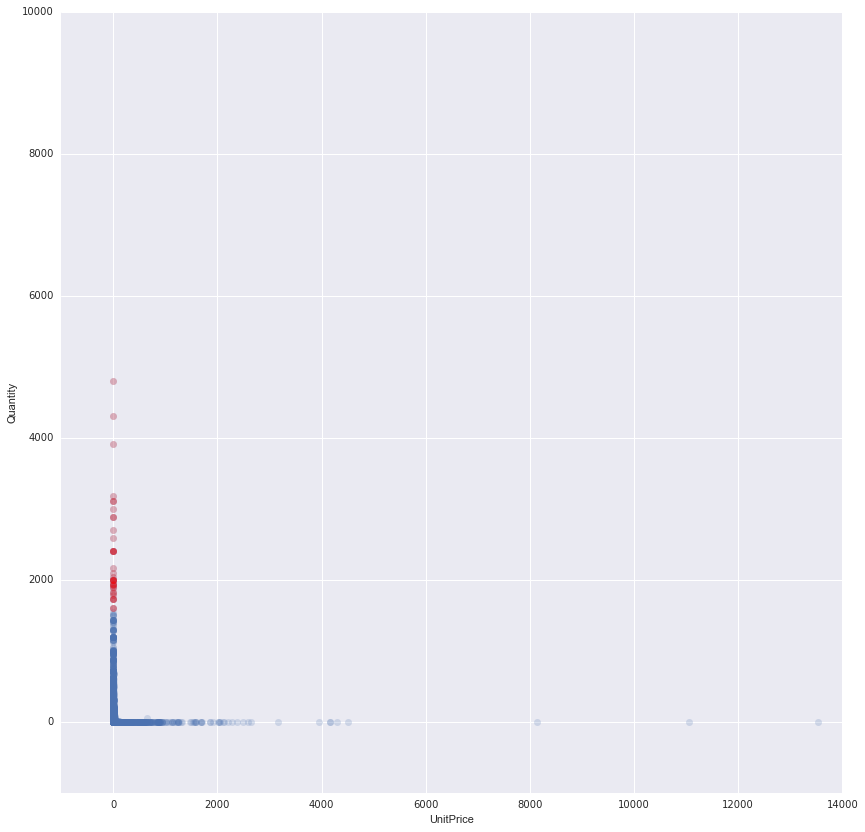

In [346]:
q = data.Quantity
p = data.UnitPrice

p = p[q < 60000]
q = q[q < 60000]

outlier_quantity = dqv[np.exp(log_pdf) < 0.0000001]
outliers_sel = np.vectorize(lambda x: x in outlier_quantity)(q)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
ax.set_xlim(-1000, 14000)
ax.set_ylim(-1000, 10000)
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

Let's do the same for UnitPrice.

In [148]:
kd = KernelDensity(bandwidth=500)
kd.fit(np.expand_dims(data.UnitPrice.values, 1))
dpv = np.unique(data.UnitPrice.values)
log_pdf = kd.score_samples(np.expand_dims(dpv, 1))

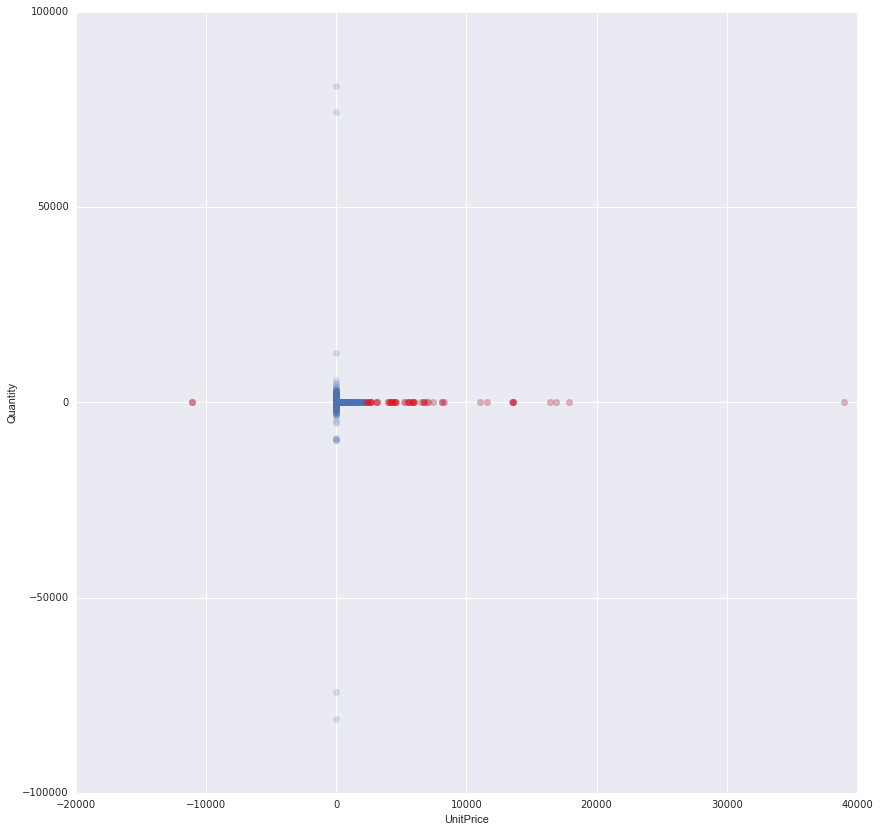

In [149]:
outlier_unitprice = dpv[np.exp(log_pdf) < 0.000000075]
outliers_sel = np.vectorize(lambda x: x in outlier_unitprice)(p)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

We can conclude that these points are global outliers because they deviate a lot from estimation. However, we can go further and analyze 2d space.

In [151]:
kd_2d = KernelDensity(bandwidth=1200)
kd_2d.fit(data[["Quantity", "UnitPrice"]].values)
arr = pd.unique(data[["Quantity", "UnitPrice"]].values)
dpqv = np.zeros((arr.shape[0], 2))
for i in range(arr.shape[0]):
    dpqv[i, :] = arr[i]
log_pdf = kd_2d.score_samples(dpqv)

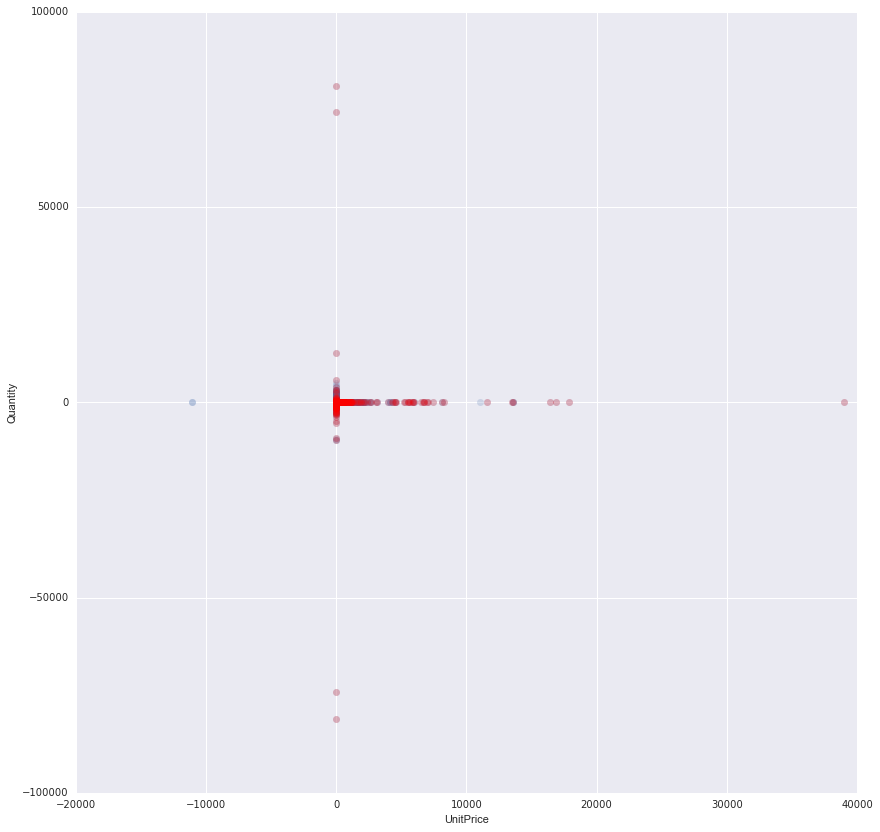

In [232]:
outlier_qtyprice = dpqv[np.exp(log_pdf) < 2.0399e-13]
outliers_sel = np.array(list(map(lambda x: [x[0], x[1]] in outlier_qtyprice, dpqv)))
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
# plt.plot(p, q, linestyle='', marker='o', alpha=.2);
# plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
plt.plot(data["UnitPrice"], data["Quantity"], linestyle='', marker='o', alpha=.2);
plt.plot(dpqv[outliers_sel, 1], dpqv[outliers_sel, 0], linestyle='', marker='o', color='r', alpha=.2)
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

However, using 2d KDE here is not very reasonable beacause of obvious structure of the data.

### Contextual outliers

In [235]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


We are definitely intend to use InvoiceNo or StockCode  as  contexts. Description can be the context, if we do some subtle natural language processing and divide the data into categories. However, the most feasible contexts here are Country and CustomerID, as well as InvoiceDate.

In [237]:
data.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

Well, we can find outliers in several most presented countries.

In [245]:
data_uk = data[data.Country == "United Kingdom"].drop("Country", axis=1)

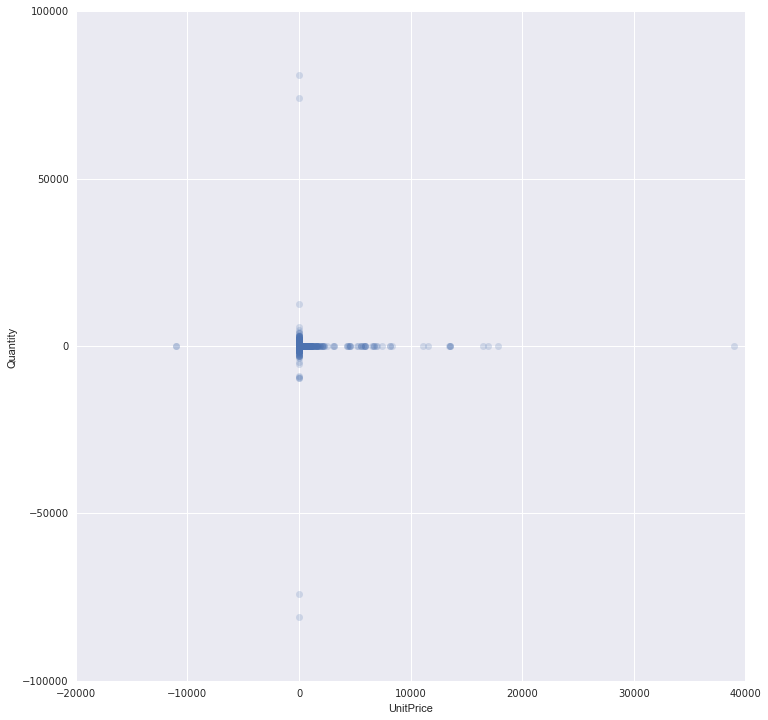

In [252]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.plot(data_uk["UnitPrice"], data_uk["Quantity"], linestyle='', marker='o', alpha=.2);
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

Looks very similar to the entire dataset (not surprisingly). Therefore, outliers will remain.

In [250]:
data_de = data[data.Country == "Germany"].drop("Country", axis=1)

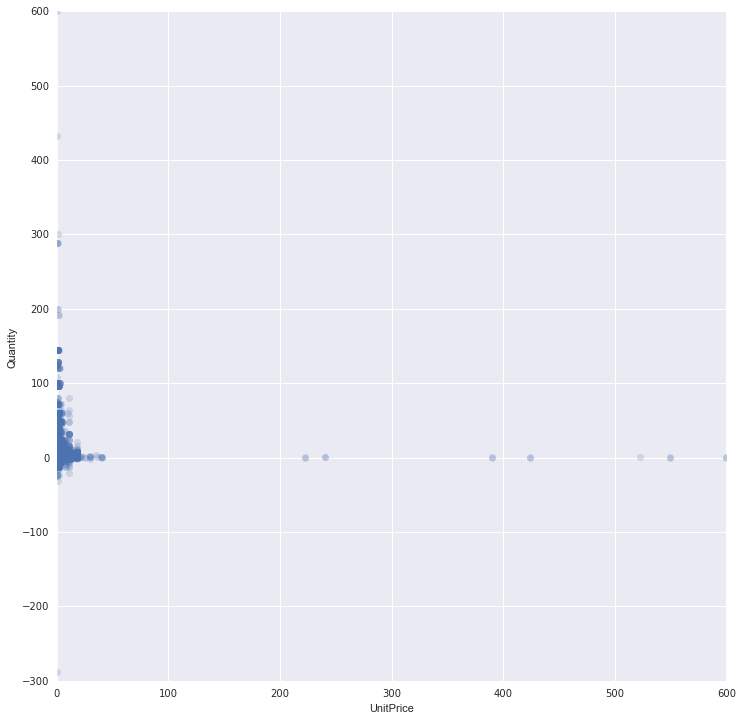

In [251]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.plot(data_de["UnitPrice"], data_de["Quantity"], linestyle='', marker='o', alpha=.2);
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

Well, very interesting. For sure we can say, that points with UnitPrice > 200 or Quantity > 200 are contextual outliers where context is "Country == Germany".

In [264]:
kd = KernelDensity(bandwidth=25)
kd.fit(np.expand_dims(data_de.Quantity.values, 1))
dqv = np.unique(data_de.Quantity.values)
log_pdf = kd.score_samples(np.expand_dims(dqv, 1))

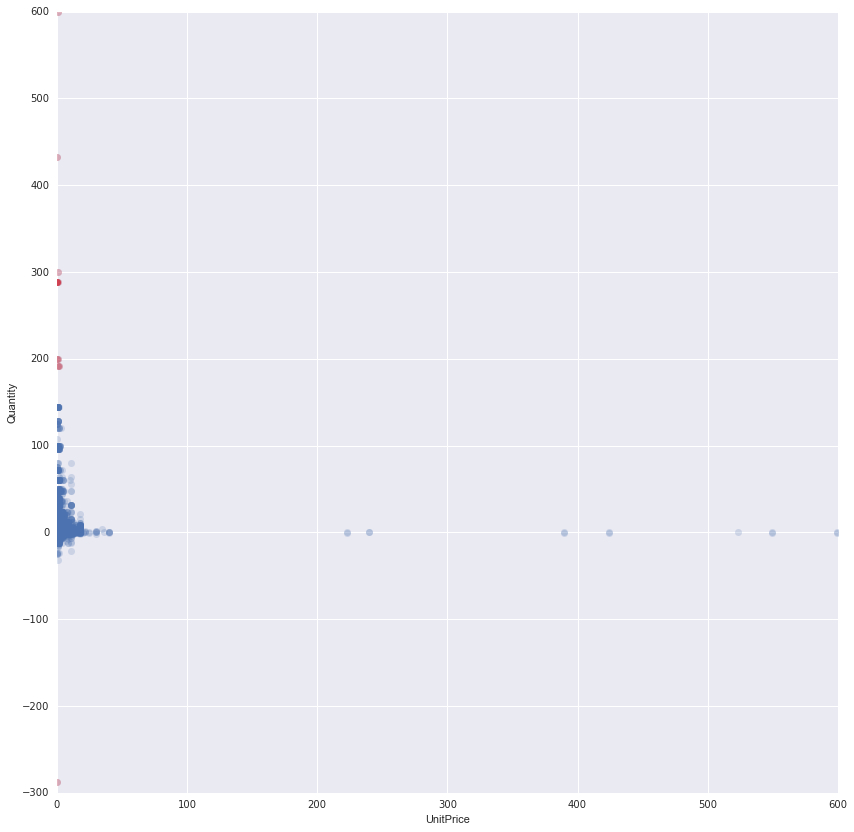

In [265]:
q = data_de.Quantity
p = data_de.UnitPrice
# For sure, here we set far lower threshold, because there are far less examples.
outlier_quantity = dqv[np.exp(log_pdf) < 0.0000375]
outliers_sel = np.vectorize(lambda x: x in outlier_quantity)(q)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

In [266]:
kd = KernelDensity(bandwidth=25)
kd.fit(np.expand_dims(data_de.UnitPrice.values, 1))
dpv = np.unique(data_de.UnitPrice.values)
log_pdf = kd.score_samples(np.expand_dims(dpv, 1))

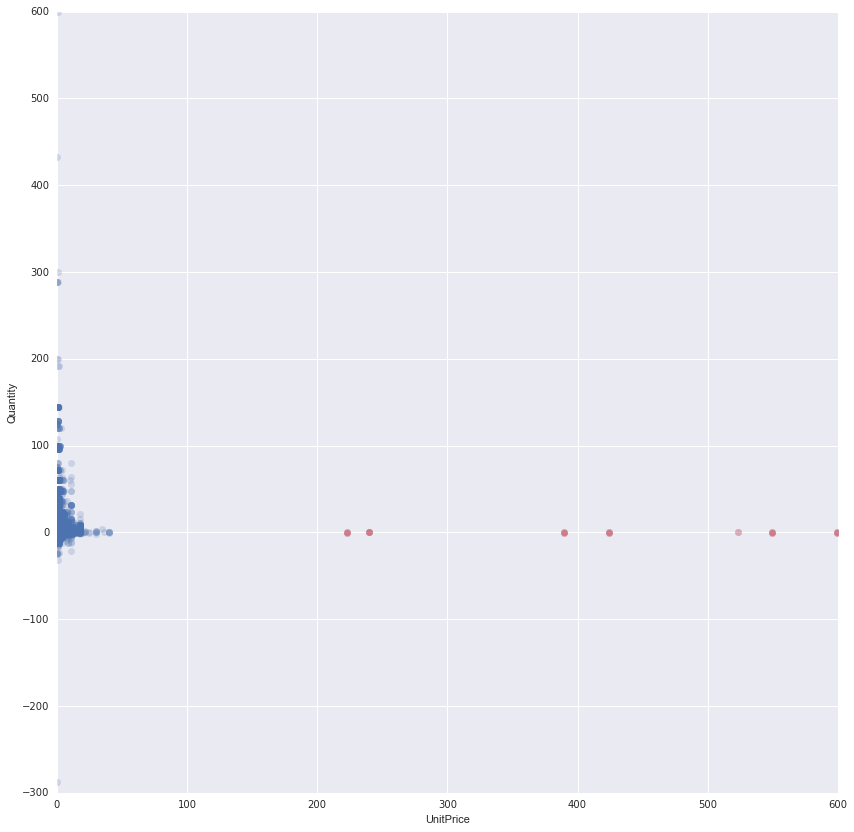

In [272]:
q = data_de.Quantity
p = data_de.UnitPrice
outlier_unitprice = dpv[np.exp(log_pdf) < 0.00075]
outliers_sel = np.vectorize(lambda x: x in outlier_unitprice)(p)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
plt.plot(p, q, linestyle='', marker='o', alpha=.2);
plt.plot(p[outliers_sel], q[outliers_sel], linestyle='', marker='o', alpha=.2, color='r');
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");

We can do the same for all countries, but the idea will stay the same. We can define 'outlierness' as inverted product of estimated (by KDE) probability of this object belonging to the main distribution and number of samples:

$$
Score(x) = \frac{1}{N * p(x)}
$$

Let's take year as context.

In [312]:
data.InvoiceDate[0].year

2010

In [316]:
year_column = data.InvoiceDate.apply(lambda d: d.year)
year_column.name = "Year"
data_year = pd.concat([data, year_column], axis=1)

In [323]:
data_2010 = data.ix[data_year.groupby("Year").groups[2010]]

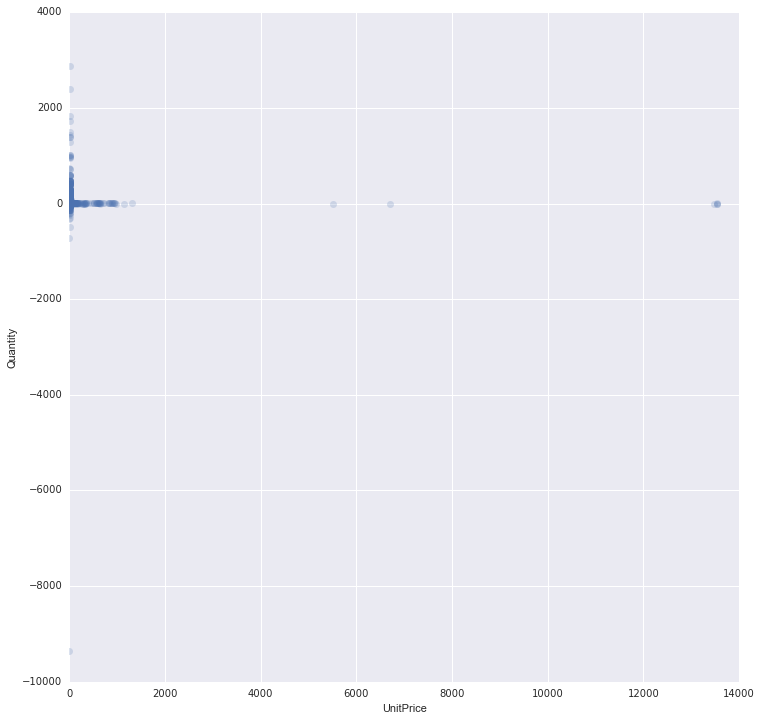

In [324]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.plot(data_2010["UnitPrice"], data_2010["Quantity"], linestyle='', marker='o', alpha=.2);
ax.set_xlabel("UnitPrice");
ax.set_ylabel("Quantity");